In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

from _analysis_functions import softmax, load_and_combine_dfs, format_cols, ExperimentMetrics, cohens_d
from _plotting import plot_compare_metric, plot_compare_images_with_confidences
plt.rcParams.update({'font.size': 14})

## Compute Metrics

In [2]:
# Get Metrics from DeepJanus Experiments
dj_metrics_e = []
for e in ["MNIST", "FashionMNIST", "SVHN"]:
    orig_df = load_and_combine_dfs(path="/home/oliver/NSExperimentation/", filters=["DeepJanus", e])
    dj_df = format_cols(orig_df, reduce_channels=True)

    dj_metrics = ExperimentMetrics(dj_df, ["X_prime_1", "X_prime_2"], ["y_prime", "y_prime_2"])
    dj_metrics_e.append(dj_metrics)

In [3]:
# Get Metrics for Sinvad experiments
sinv_iters = []
sinv_metrics_e = []
for e in ["mnist", "fmnist", "svhn", "cifar10", "imagenet"]:
    sin_df = load_and_combine_dfs(path="/home/oliver/NSExperimentation/", filters=["sinvad", e])
    sin_df = format_cols(sin_df, reduce_channels=True)
    for yc in ["y", "y_prime"]:  # Format some columns
        sin_df[yc] = sin_df[yc].apply(lambda x: softmax(x.squeeze()))

    sinv_iters.append(sin_df["iter"].tolist())
    sinv_metrics = ExperimentMetrics(sin_df, ["X_prime"], ["y_prime"])
    sinv_metrics_e.append(sinv_metrics)

In [4]:
# Get Metrics for SMOO experiments
exps = ["MNIST","FashionMNIST", "SVHN", "CIFAR10"]
smoo_metrics_e = []
for e in exps:
    smoo_df = pd.read_csv(f"results/results_lmt_{e}_wrn_sg2_ubtgn.csv")
    smoo_df = format_cols(smoo_df, reduce_channels=True)

    smoo_df["y"] = smoo_df["y"].apply(lambda x: softmax(x.squeeze()))

    smoo_metrics = ExperimentMetrics(smoo_df, ["X_prime"], ["y_prime"])
    smoo_metrics_e.append(smoo_metrics)
# Imagenet stuff.
dfs = [pd.read_csv(f"results/results_lmt_Imagenet_wrn_sgXL_ubtgn_{i}.csv") for i in range(10)]
im_smoo_df = pd.concat(dfs, ignore_index=True)
im_smoo_df = format_cols(im_smoo_df, reduce_channels=True)

im_smoo_df["y"] = im_smoo_df["y"].apply(lambda x: softmax(x.squeeze()))
im_smoo_metrics = ExperimentMetrics(im_smoo_df, ["X_prime"], ["y_prime"])
smoo_metrics_e.append(im_smoo_metrics)

In [5]:
all_exps = exps + ["Imagenet"]

## Generate Plots

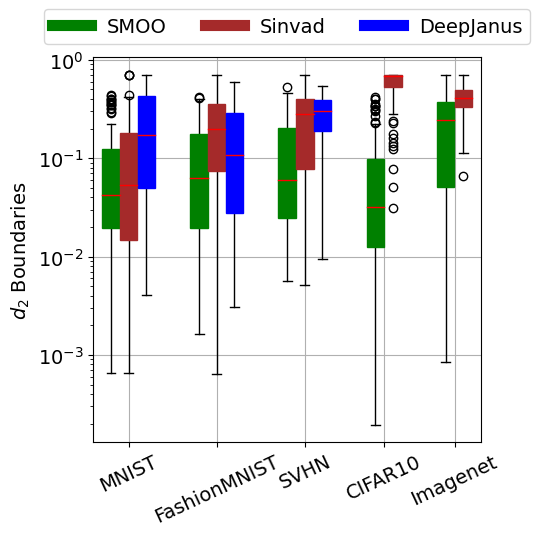

In [6]:
smoo = [e.boundary_distance for e in smoo_metrics_e]
sinv = [e.boundary_distance for e in sinv_metrics_e]
dj = [e.boundary_distance for e in dj_metrics_e]

plot_compare_metric(smoo, sinv, dj, exp_labels=["SMOO", "Sinvad", "DeepJanus"], tick_labels=all_exps, name="$d_2$ Boundaries", log=True, save_as="figures/rq1/boundaries_comp")

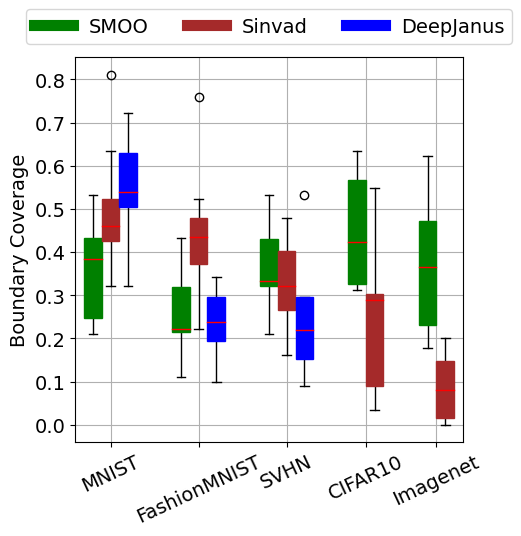

In [8]:
smoo_c = [e.coverage for e in smoo_metrics_e]
sinv_c = [e.coverage for e in sinv_metrics_e]
dj_c = [e.coverage for e in dj_metrics_e]

plot_compare_metric(smoo_c, sinv_c, dj_c, exp_labels=["SMOO", "Sinvad", "DeepJanus"], tick_labels=all_exps, name="Boundary Coverage", save_as="figures/rq1/boundary_coverage_comp")

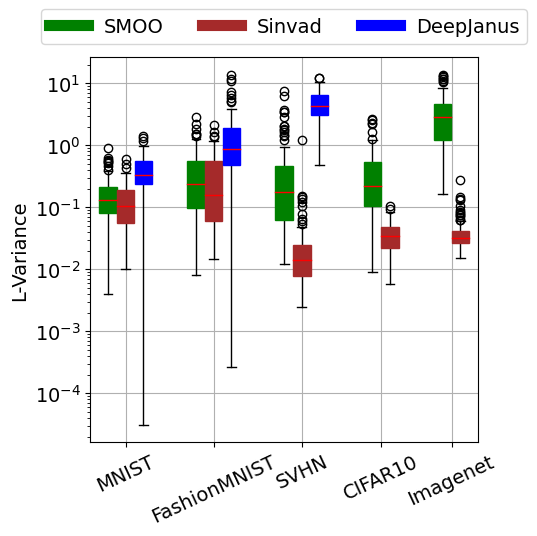

In [9]:
smoo = [e.lap_variance for e in smoo_metrics_e]
sinv = [e.lap_variance for e in sinv_metrics_e]
dj = [e.lap_variance for e in dj_metrics_e]

plot_compare_metric(smoo, sinv, dj, exp_labels=["SMOO", "Sinvad", "DeepJanus"], tick_labels=all_exps, name="L-Variance", log=True, save_as="figures/rq1/lap_variance_comp")

### Evaluation Table Contents

In [10]:
# Escape Ratio Data
smoo_e = sum([e.escape_ratios for e in smoo_metrics_e], [])
sinv_e = sum([e.escape_ratios for e in sinv_metrics_e], [])
dj_e = sum([e.escape_ratios for e in dj_metrics_e], [])

print("Escape ratios SMOO: ", smoo_e)
print("Escape ratios Sinvad: ", sinv_e)
print("Escape ratios DeepJanus: ", dj_e)

Escape ratios SMOO:  [0.0, 0.0, 0.01, 0.0, 0.07]
Escape ratios Sinvad:  [0.01, 0.05, 0.23, 0.3, 0.59]
Escape ratios DeepJanus:  [0.02, 0.13, 0.28]


In [11]:
# Statistical Analysis of Metrics
results_table = {}
for i, dataset in enumerate(all_exps):
    results_table[dataset] = {}

    """Get statistics."""
    for method, metric in zip(["Sinvad", "DeepJanus"], [sinv_metrics_e, dj_metrics_e]):
        if len(metric) > i:
            results_table[dataset][method] = {}
        else:
            continue

        bdist = mannwhitneyu(smoo_metrics_e[i].boundary_distance, metric[i].boundary_distance, alternative="less")[1]
        if bdist < 0.05:
            bdist = [bdist, cohens_d(smoo_metrics_e[i].boundary_distance, metric[i].boundary_distance)]
        results_table[dataset][method]["boundary_dist"] = bdist

        lvar = mannwhitneyu(smoo_metrics_e[i].lap_variance, metric[i].lap_variance, alternative="greater")[1]
        if lvar < 0.05:
            lvar = [lvar, cohens_d(smoo_metrics_e[i].lap_variance, metric[i].lap_variance)]
        results_table[dataset][method]["lap_var"] = lvar

        cov = mannwhitneyu(smoo_metrics_e[i].coverage, metric[i].coverage, alternative="greater")[1]
        if cov < 0.05:
            cov = [cov, cohens_d(smoo_metrics_e[i].coverage, metric[i].coverage)]
        results_table[dataset][method]["cov"] = cov

        results_table[dataset][method]["imdist"] = \
        mannwhitneyu(smoo_metrics_e[i].image_distance, metric[i].image_distance, alternative="greater")[1]

results_table

{'MNIST': {'Sinvad': {'boundary_dist': 0.2833309142195083,
   'lap_var': [0.014601896868440163, 0.31087309639212063],
   'cov': 0.9861726769357306,
   'imdist': 8.662568710073778e-11},
  'DeepJanus': {'boundary_dist': [1.1922989410342722e-07, -0.831293429777097],
   'lap_var': 0.9999999999999999,
   'cov': 0.9989571642128927,
   'imdist': 1.0}},
 'FashionMNIST': {'Sinvad': {'boundary_dist': [9.518529030655355e-07,
    -0.7659190071683559],
   'lap_var': 0.08352632435708329,
   'cov': 0.998039715836304,
   'imdist': 2.1157064299388003e-06},
  'DeepJanus': {'boundary_dist': [0.005622109983908458, -0.40635373619271037],
   'lap_var': 0.9999999999996922,
   'cov': 0.32470430842540254,
   'imdist': 1.0}},
 'SVHN': {'Sinvad': {'boundary_dist': [5.213325530018851e-09,
    -0.9388463591582962],
   'lap_var': [1.6141025776269256e-27, 0.6815989073106106],
   'cov': 0.21350375154221196,
   'imdist': 3.9859316261563134e-16},
  'DeepJanus': {'boundary_dist': [7.746183578634879e-15, -1.2900061644809

### Show Image Comparison

In [12]:
plt.rcParams.update({'font.size': 24})

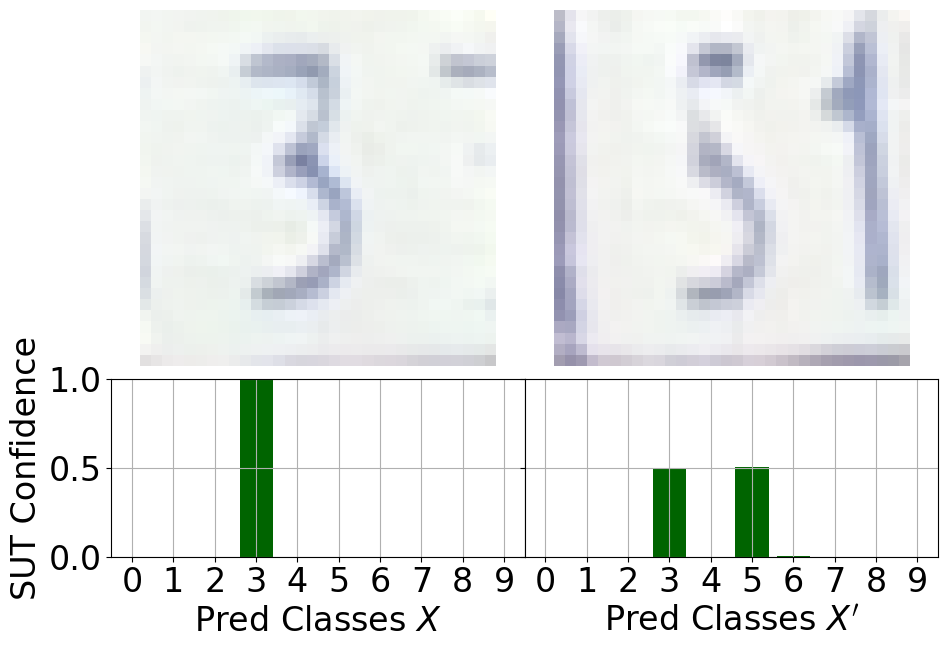

In [13]:
# SMOO SVHN
df = format_cols(pd.read_csv("results/results_lmt_SVHN_wrn_sg2_ubtgn.csv"), reduce_channels=False)
dp = 30
elem, y = df["X"][dp].transpose(1, 2, 0), softmax(df["y"][dp].flatten())
elem2, yp = df["X_prime"][dp].transpose(1, 2, 0), df["y_prime"][dp]
plot_compare_images_with_confidences(elem, elem2, y, yp, save_as="figures/rq1/SMOO_SVHN_example")

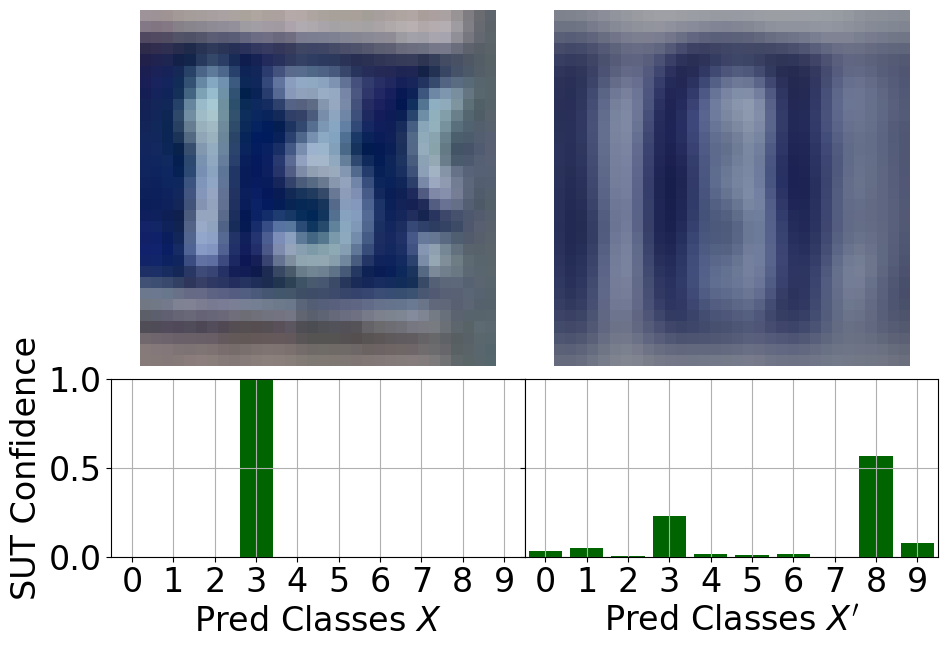

In [14]:
# Sinvad SVHN
df = format_cols(load_and_combine_dfs(path="/home/oliver/NSExperimentation/", filters=["sinvad", "svhn"]), reduce_channels=False)
dp = 1
elem, y = df["X"][dp].transpose(1,2,0), softmax(df["y"][dp].flatten())
elem2, yp = df["X_prime"][dp].transpose(1,2,0), softmax(df["y_prime"][dp].flatten())
plot_compare_images_with_confidences(elem, elem2, y, yp, save_as="figures/rq1/Sinvad_SVHN_example")

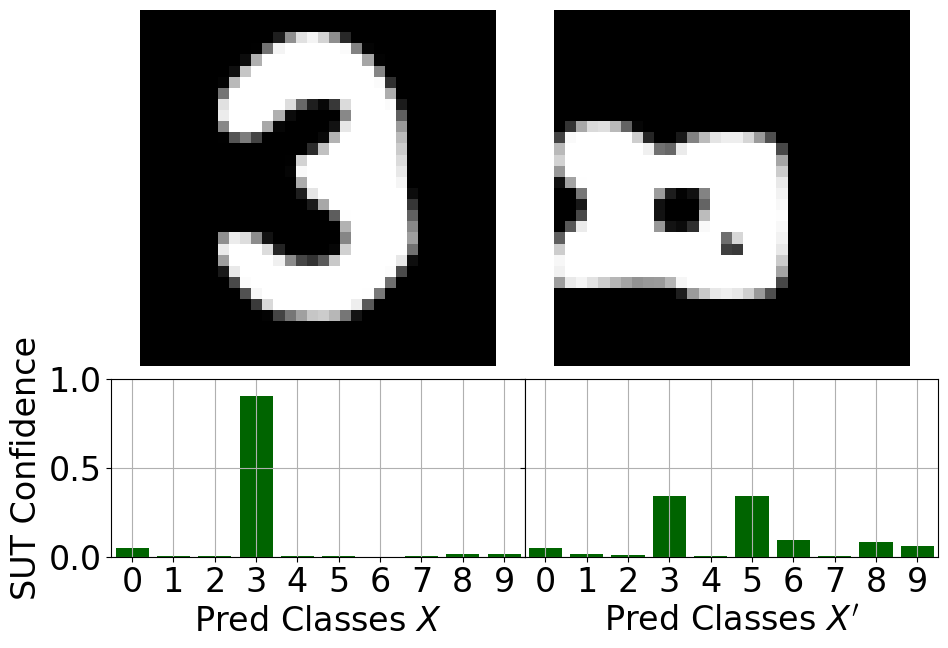

In [15]:
# DeepJanus SVHN
df = format_cols(load_and_combine_dfs(path="/home/oliver/NSExperimentation/", filters=["DeepJanus", "SVHN"]), reduce_channels=False)
dp = 1
elem, y = df["X"][dp].transpose(1,2,0), df["y"][dp].flatten()
elem2, yp = df["X_prime_1"][dp].transpose(1,2,0), df["y_prime"][dp].flatten()
plot_compare_images_with_confidences(elem, elem2, y, yp, save_as="figures/rq1/DeepJanus_SVHN_example")

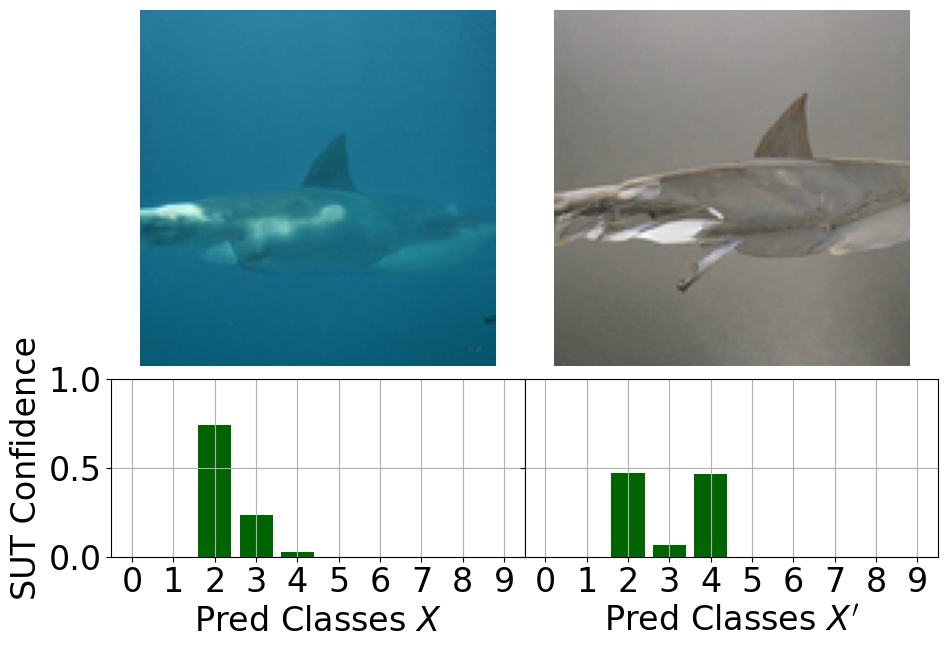

In [16]:
# SMOO Imagenet
dfs = [pd.read_csv(f"results/results_lmt_Imagenet_wrn_sgXL_ubtgn_{i}.csv") for i in range(10)]
df = format_cols(pd.concat(dfs, ignore_index=True))
dp = 21# 98, 15,
elem, y = df["X"][dp].transpose(1,2,0), softmax(df["y"][dp].flatten())
elem2, yp = df["X_prime"][dp].transpose(1,2,0), df["y_prime"][dp].flatten()
plot_compare_images_with_confidences(elem, elem2, y, yp, save_as="figures/rq1/SMOO_Imagenet_example")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


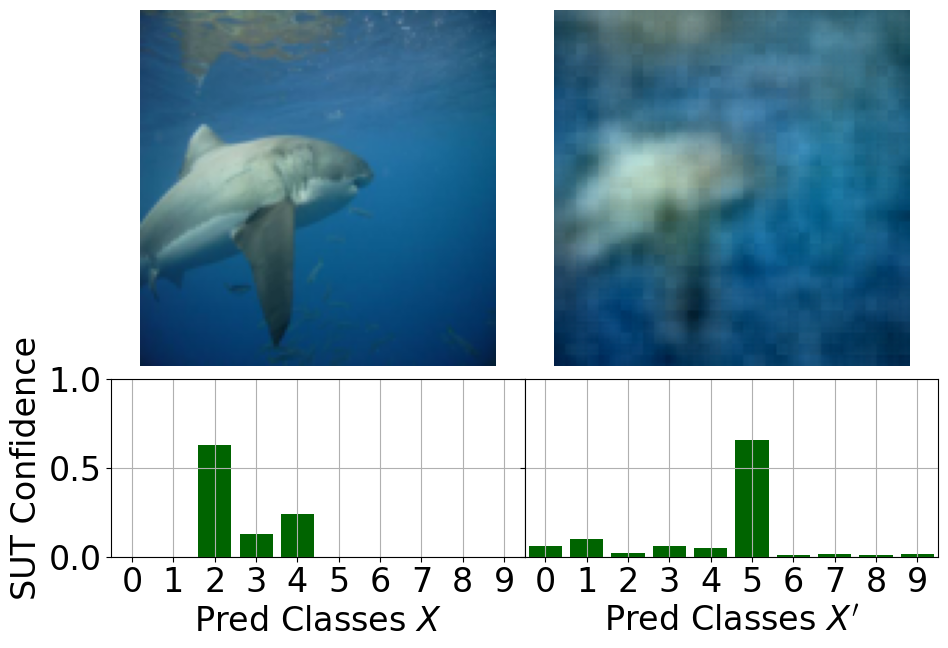

In [17]:
# Sinvad Imagenet
df = format_cols(load_and_combine_dfs(path="/home/oliver/NSExperimentation/", filters=["sinvad", "imagenet"]))
dp = 43
elem, y = df["X"][dp].transpose(1,2,0), softmax(df["y"][dp].flatten())
elem2, yp = df["X_prime"][dp].transpose(1,2,0), softmax(df["y_prime"][dp].flatten())
plot_compare_images_with_confidences(elem, elem2, y, yp, save_as="figures/rq1/Sinvad_Imagenet_example")